# SNP Classificator

Wiktoria Wilman <br>
Wroclaw University of Environmental and Life Sciences <br>
Classes: Data Analysis 

_______________________________________________________________________

Data owner: Theta Statistical Genetics Group (http://theta.edu.pl/)
Data contains samples of SNP and description of the authenticity of each genotype. Data comes from 4 "traditional Danish Red Dairy Cattle" bulls, sequenced in Next Generation Sequencing by Illumina. There are 12 variables:
- Genotype - 0 is false SNP, 1 is true SNP,
- QUAL = −10 ∙ 𝑙𝑜𝑔10[𝑃(𝐴𝐿𝑇 is wrong)],
- DP - coverage of the reference genome,
- DP2 - coverage of the reference genome on second level.
- 𝐺𝑄 = −10 ∙ 𝑙𝑜𝑔10[𝑃(genotype is wrong|SNP)],
- BEFORE1,2,3 - Three nucleotides before the SNP,
- BEHIND1,2,3 - Three nucleotides after the SNP.

__________________________________________________________________________________________________________________

## 1. Providing the required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas_profiling 
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_auc_score
from sklearn.impute import KNNImputer
from pandas_profiling import ProfileReport
from keras import backend as K
from keras.layers import Dropout
from sklearn.metrics import roc_curve,auc
from sklearn.preprocessing import StandardScaler

## 2. Data load

In [3]:
data = pd.read_csv('data.txt', sep=';', dtype={'genotype':'float32'})

## 3. Basic data description

In [4]:
data.shape

(2294151, 12)

We have 2294151 of SNPs described by 12 columns.

In [5]:
data.head()

genotype   QUAL  DP   DP2     GQ  CALL BEFORE1 BEFORE2 BEFORE3 BEHIND1  \
0       1.0  87093  74  50.0   63.0     3       C       C       A       A   
1       1.0  56419  64   9.0  100.0     3       A       G       G       A   
2       1.0  40180  68  48.0    NaN     2       A       G       G       T   
3       1.0  33677  57  48.0    3.0     3       C       A       C       G   
4       1.0  78396  51  50.0   21.0     5       A       A       T       A   

  BEHIND2 BEHIND3  
0       A       A  
1       C       A  
2       A       A  
3       G       G  
4       A       A

The first column is crucial in case of our prediction, it's our dependent variable.

We can see all data summary below.

In [6]:
data.profile_report()

## 4. Preprocessing

How many SNPs do we have in each class?

In [7]:
true_SNP = data[data['genotype'] == 1].shape[0]
false_SNP = data[data['genotype'] == 0].shape[0]

In [8]:
print('Procentage of true SNP: ',(str(round(true_SNP * 100 / (true_SNP + false_SNP), 2))))
print('Procentage of false SNP: ',str(round(false_SNP * 100 / (true_SNP + false_SNP), 2)))

Procentage of true SNP:  96.74
Procentage of false SNP:  3.26


In [9]:
true_SNP = data[data['genotype'] == 1].shape[0]
false_SNP = data[data['genotype'] == 0].shape[0]

As we can see, the data is biased. There is much more true SNPs than false, we need to keep that in mind for later and change genotype designation.

In [10]:
data['genotype'][data['genotype'] == 0.0] = 2.0
data['genotype'][data['genotype'] == 1.0] = 0.0
data['genotype'][data['genotype'] == 2.0] = 1.0

/home/kons/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/kons/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/kons/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipyk

Next we decided to use triplets as an information before and after SNP so we connect nucleotides' columns to triplets.

In [11]:
data['BEFORE'] = data['BEFORE1'] + data['BEFORE2'] + data['BEFORE3']
data['BEHIND'] = data['BEHIND1'] + data['BEHIND2'] + data['BEHIND3']
data = data.drop(['BEFORE1','BEFORE2','BEFORE3','BEHIND1','BEHIND2','BEHIND3'], axis=1)

## 5. Description after preprocessing

In [12]:
data.profile_report()

## 6. Dealing with missing data

We can see that GQ has 24.6% missing data, so we need to deal with it - I decided to delete this variable. Next in DP2 is only 1% missing so I went for imputation with median.

In [13]:
data['DP2']=data['DP2'].fillna(data['DP2'].median())

In [14]:
data = data.dropna(axis=1)

In [15]:
data = pd.get_dummies(data, prefix=['BEFORE', 'BEHIND'])

## 7. Final data description

In [16]:
data.shape

(2294151, 135)

We changed our nucleotides to triplets and the 12 columns was converted to 135, because we generated a occurance matrix of triplets, which you can see below.

In [17]:
data.head()

genotype   QUAL  DP   DP2  CALL  BEFORE_AAA  BEFORE_AAC  BEFORE_AAG  \
0       0.0  87093  74  50.0     3           0           0           0   
1       0.0  56419  64   9.0     3           0           0           0   
2       0.0  40180  68  48.0     2           0           0           0   
3       0.0  33677  57  48.0     3           0           0           0   
4       0.0  78396  51  50.0     5           0           0           0   

   BEFORE_AAT  BEFORE_ACA  ...  BEHIND_TCG  BEHIND_TCT  BEHIND_TGA  \
0           0           0  ...           0           0           0   
1           0           0  ...           0           0           0   
2           0           0  ...           0           0           0   
3           0           0  ...           0           0           0   
4           1           0  ...           0           0           0   

   BEHIND_TGC  BEHIND_TGG  BEHIND_TGT  BEHIND_TTA  BEHIND_TTC  BEHIND_TTG  \
0           0           0           0           0           0           0   
1           0           0           0           0           0           0   
2           0           0           0           0           0           0   
3           0           0           0           0           0           0   
4           0           0           0           0           0           0   

   BEHIND_TTT  
0           0  
1           0  
2           0  
3           0  
4           0  

[5 rows x 135 columns]

## 8. Sepatarion to test and training data

We need to separate the data.

In [18]:
data_x = data.iloc[:, 1:]
data_y = data.iloc[:, :1]

In [19]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, stratify=data_y, test_size=0.1, random_state=10)


We check of the ratio in the test and training to be sure that daya got a fine split.

In [20]:
y_train.genotype.value_counts()[0] / (y_train.genotype.value_counts()[1] + y_train.genotype.value_counts()[0])

0.9674108299612298

In [21]:
y_test.genotype.value_counts()[0] / (y_test.genotype.value_counts()[1] + y_test.genotype.value_counts()[0])


0.967412909300136

We use standardization with Z-score method on the numeric columns, it depends on the number of std that our variable is from the mean variable.

In [22]:
def standardize(column):
    mean = x_train[column].mean()
    std = x_train[column].std()
    x_train.loc[:, column] = (x_train[column] - mean) / std
    x_test.loc[:, column] = (x_test[column] - mean) / std

In [23]:
standardize('QUAL')
standardize('DP')
standardize('DP2')
standardize('CALL')

/home/kons/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Spliting into training and validation

In [24]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, stratify=y_train, test_size=0.1, random_state=11)

In [25]:
input_shape = x_train.shape[1]
x_train.shape

(1858261, 134)

# 9. Model

Functions for later use.

In [27]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
        precision = precision_m(y_true, y_pred)
        recall = recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))

Model we build is based on relu and sigmoid function, because of their susceptibility to binary classification. We also use dropout and earlystopping to protect our model from overfitting (often in biased data model classificate all data as the most common one - we want to prevent that from occuring).

In [28]:
model = Sequential()
model.add(Dense(512, input_shape=(134,), activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
    
model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=[f1_m])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 512)               69120     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 32)               

In [30]:
def recall_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

def precision_m(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

def f1_m(y_true, y_pred):
        precision = precision_m(y_true, y_pred)
        recall = recall_m(y_true, y_pred)
        return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [31]:
callback_list = [
    EarlyStopping(
        monitor='f1_m',
        patience=3,
        mode='max'
    )
]

In [32]:
history = model.fit(x_train, y_train, 
          batch_size=512, 
          epochs=300,
          callbacks=callback_list,
          validation_data=(x_val, y_val))

Epoch 1/300
3630/3630 [==============================] - 25s 7ms/step - loss: 0.1065 - f1_m: 0.4341 - val_loss: 0.1071 - val_f1_m: 0.4752
Epoch 2/300
3630/3630 [==============================] - 35s 10ms/step - loss: 0.0957 - f1_m: 0.4694 - val_loss: 0.0975 - val_f1_m: 0.4752
Epoch 3/300
3630/3630 [==============================] - 35s 10ms/step - loss: 0.0942 - f1_m: 0.4691 - val_loss: 0.0972 - val_f1_m: 0.4726
Epoch 4/300
3630/3630 [==============================] - 34s 9ms/step - loss: 0.0935 - f1_m: 0.4692 - val_loss: 0.0988 - val_f1_m: 0.4752
Epoch 5/300
3630/3630 [==============================] - 34s 9ms/step - loss: 0.0927 - f1_m: 0.4706 - val_loss: 0.0968 - val_f1_m: 0.4752
Epoch 6/300
3630/3630 [==============================] - 35s 10ms/step - loss: 0.0918 - f1_m: 0.4707 - val_loss: 0.0961 - val_f1_m: 0.4752
Epoch 7/300
3630/3630 [==============================] - 38s 11ms/step - loss: 0.0909 - f1_m: 0.4722 - val_loss: 0.0949 - val_f1_m: 0.4752
Epoch 8/300
3630/3630 [=======

Epoch 60/300
3630/3630 [==============================] - 41s 11ms/step - loss: 0.0682 - f1_m: 0.5689 - val_loss: 0.1116 - val_f1_m: 0.4818
Epoch 61/300
3630/3630 [==============================] - 40s 11ms/step - loss: 0.0682 - f1_m: 0.5678 - val_loss: 0.1138 - val_f1_m: 0.4803
Epoch 62/300
3630/3630 [==============================] - 41s 11ms/step - loss: 0.0681 - f1_m: 0.5685 - val_loss: 0.1092 - val_f1_m: 0.4825
Epoch 63/300
3630/3630 [==============================] - 40s 11ms/step - loss: 0.0678 - f1_m: 0.5700 - val_loss: 0.1104 - val_f1_m: 0.4806
Epoch 64/300
3630/3630 [==============================] - 41s 11ms/step - loss: 0.0674 - f1_m: 0.5722 - val_loss: 0.1131 - val_f1_m: 0.4802
Epoch 65/300
3630/3630 [==============================] - 41s 11ms/step - loss: 0.0675 - f1_m: 0.5700 - val_loss: 0.1153 - val_f1_m: 0.4804
Epoch 66/300
3630/3630 [==============================] - 40s 11ms/step - loss: 0.0671 - f1_m: 0.5724 - val_loss: 0.1099 - val_f1_m: 0.4796
Epoch 67/300
3630/36

# 10. Evaluation

In [33]:
results = model.evaluate(x_test, y_test)
print('Final loss: ', results[0])
print('Final F1-score: ', results[1])

7170/7170 [==============================] - 8s 1ms/step - loss: 0.1248 - f1_m: 0.2333
Final loss:  0.12484604865312576
Final F1-score:  0.23331521451473236


Loss about 0.125 and f1-score about 0.23 - we can claim that it is accountable.

In [34]:
y_pred = model.predict(x_test)
y_pred_class = model.predict_classes(x_test)
cm = confusion_matrix(y_test,y_pred_class)
cr = classification_report(y_test,y_pred_class)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


[Text(0, 0.5, '0'), Text(0, 1.5, '1')]

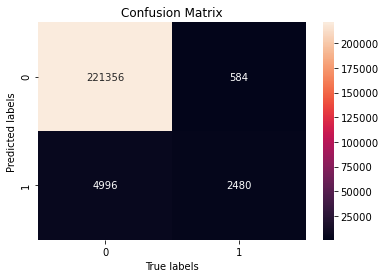

In [35]:
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax = ax)
ax.set_xlabel('True labels');ax.set_ylabel('Predicted labels') 
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['0', '1'])
ax.yaxis.set_ticklabels(['0', '1'])

Based on Confusion Matrix we can see that part of the true SNPs are recognized as false (4996) and the number is lower that the number of true and false labeled false SNPs (3064).

In [36]:
print(cr)

print('Final Precision:', str(round(cm[0][0] * 100 / (cm[0][0] + cm[1][0]), 2)) + '%')
print(' Final Sensitivity:', str(round(cm[0][0] * 100 / (cm[0][0] + cm[0][1]),2)) + '%')
print(' Final Specificity:', str(round((cm[1][1] *100 / (cm[1][1] + cm[0][1])),2)) + '%')

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99    221940
         1.0       0.81      0.33      0.47      7476

    accuracy                           0.98    229416
   macro avg       0.89      0.66      0.73    229416
weighted avg       0.97      0.98      0.97    229416

Final Precision: 97.79%
 Final Sensitivity: 99.74%
 Final Specificity: 80.94%


The two most informative are (in my opinion in that case): <br>
Sensivity is the ratio of the false SNPs that were correctly labeled by our program to all. <br>
Accuracy is the ratio of the correctly labeled subjects to the whole pool of subjects.

In [37]:
balanced_accuracy_score(y_test, y_pred_class)

0.6645484275463225

The balanced accuracy is adjusted to adapt to biased binary data. In that case it is not perfect, but fine.

In [38]:
matthews_corrcoef(y_test, y_pred_class)

0.509025595608858

Matthews correlation cofficent is another way to check the quality of binary classification. In that case it indicates partial agreement between prediction and observation.

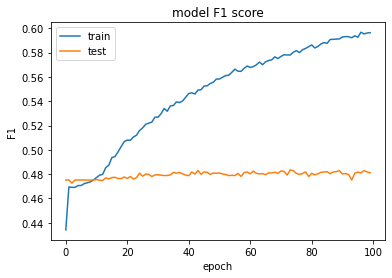

In [39]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])
plt.title('model F1 score')
plt.ylabel('F1')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

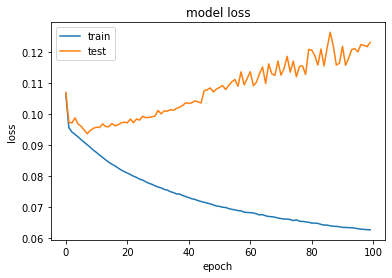

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [41]:
lw = 2
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)
def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr,color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.legend(loc="lower right")
  plt.show()    

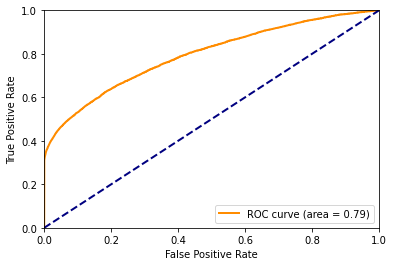

In [42]:
lw = 2
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)   
plot_roc_curve (fpr,tpr)

ROC curve tells us about the trade-off between sensitivity (or TPR) and specificity (1 – FPR). In this case it's good.

# 11. Conclusions

Such data with bias are realy hard to deal with, unfortunatelly variables do not describe genotype well. My way of completing project was not the best, but best for me at the time (2019/2020) as my first ML usage. If you have any questions or your own conclusions - contact me!


# 12. References

Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow. O'Reilly Media

https://morioh.com/p/134b77787d2a <br>
https://www.scipy.org/ <br>
https://scikit-learn.org/stable/ <br>